# Описание задачи

Многие знают про маркетплейсы где продаются б/у вещи, на которых есть возможность недорого купить качественную и полезную вещь. Но всегда волнует вопрос - кто и как устанавливает цену, и какие его характеристики больше всего влияют на итоговую стоимость продажи?! Вопрос становиться особо актуальным, если речь идет про дорогие товары, например про автомобили!
Целью проекта будет разработанная модель предсказания стоимости автомобиля на вторичном рынке.



## Данные


- `train.csv` - информация о характеристиках автомобилей (~440000), которые будут использоваться в качестве обучающих данных;
- `test.csv` - информация о характеристиках автомобилей (~110000), которые будут использоваться в качестве тестовых данных. Задача - предсказать значение `sellingprice` для каждого автомобиля из этого датасета;
- `sample_submission.csv` - пример файла предсказаний в правильном формате.

## Описание полей данных

- `Date` - год выпуска автомобиля;
- `Make` - марка автомобиля;
- `Model`- издание автомобиля определенной марки;
- `Trim` - уровень отделки салона автомобиля;
- `Body` - тип кузова транспортного средства;
- `Transmission` - тип коробки передач;
- `VIN` - идентификационный номер транспортного средства;
- `State` - штат;
- `Condition` - состояние автомобилей на момент аукциона;
- `Odometer` - расстояние, пройденное автомобилем с момента выпуска;
- `Color` - цвет кузова автомобиля;
- `Interior` - цвет салона автомобиля;
- `Seller` - продавец автомобиля, автосалоны;
- `Saledate` - дата продажи автомобиля;
- `Sellingprice` - цена, по которой автомобиль был продан на аукционе.


# Загрузка данных

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle competitions download used-cars-price-prediction-21ds -f test.csv
!unzip test.csv

  0% 0.00/4.18M [00:00<?, ?B/s]
100% 4.18M/4.18M [00:00<00:00, 68.9MB/s]
Archive:  test.csv.zip
  inflating: test.csv                


In [ ]:
 !kaggle competitions download used-cars-price-prediction-21ds -f train.csv
 !unzip train.csv

 50% 9.00M/17.8M [00:00<00:00, 13.8MB/s]
100% 17.8M/17.8M [00:00<00:00, 25.7MB/s]
Archive:  train.csv.zip
  inflating: train.csv               


In [ ]:
!rm test.csv.zip
!rm train.csv.zip

# Импорт библиотек

In [ ]:
!pip install catboost
!pip install optuna
!pip install category_encoders

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, FunctionTransformer, StandardScaler, PolynomialFeatures
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder
from sklearn.base import BaseEstimator, TransformerMixin

from catboost import CatBoostRegressor
import optuna

In [ ]:
pd.options.mode.chained_assignment = None

# Загрузка данных и первичный анализ

In [ ]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [ ]:
def describe_my_data(data):
    print('Общая информация:', end='\n\n')
    print(data.info(), end='\n\n')
    print('Количество пропусков:')
    print(data.isna().sum(), end='\n\n')
    print(f'Количество явных дубликатов - {data.duplicated().sum()}', end='\n\n')
    print('Коэффициенты корреляции:')
    print(data.corr(), end='\n\n')
    plt.figure(figsize=(5, 5))
    sns.heatmap(data.corr().round(2), annot=True, square=True)
    plt.show();

In [ ]:
def hist_my_data(data, types=('number'), size=(20, 5)):
    for col in data.select_dtypes(types).columns:
        plt.figure(figsize=size)
        plt.xticks(rotation=0)
        sns.histplot(x=data[col])
        plt.show()

Общая информация:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 50.4+ MB
None

Количество пропусков:
year                0
make    

<ipython-input-17-2d3198fe388b>:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(data.corr(), end='\n\n')
<ipython-input-17-2d3198fe388b>:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr().round(2), annot=True, square=True)


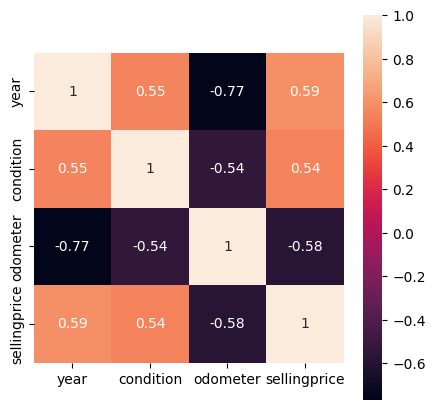

In [ ]:
describe_my_data(df_train)

Общая информация:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          110058 non-null  int64  
 1   make          107997 non-null  object 
 2   model         107979 non-null  object 
 3   trim          107944 non-null  object 
 4   body          107464 non-null  object 
 5   transmission  97047 non-null   object 
 6   vin           110058 non-null  object 
 7   state         110058 non-null  object 
 8   condition     107679 non-null  float64
 9   odometer      110039 non-null  float64
 10  color         109900 non-null  object 
 11  interior      109900 non-null  object 
 12  seller        110058 non-null  object 
 13  saledate      110058 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 11.8+ MB
None

Количество пропусков:
year                0
make             2061
model            2079
trim    

<ipython-input-17-2d3198fe388b>:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(data.corr(), end='\n\n')
<ipython-input-17-2d3198fe388b>:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr().round(2), annot=True, square=True)


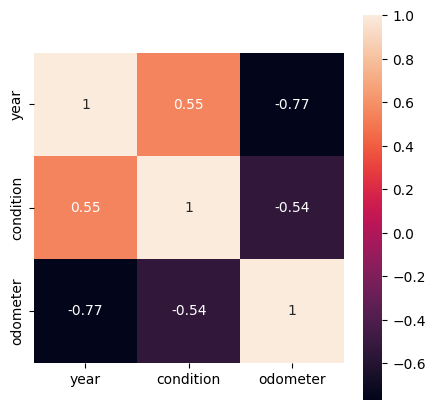

In [ ]:
describe_my_data(df_test)

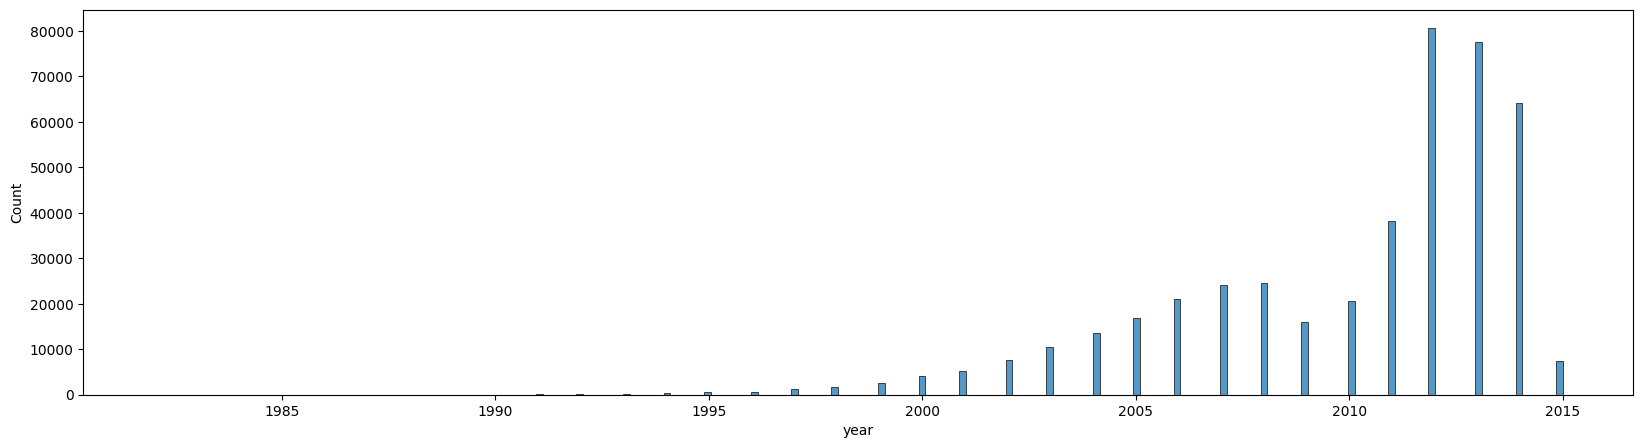

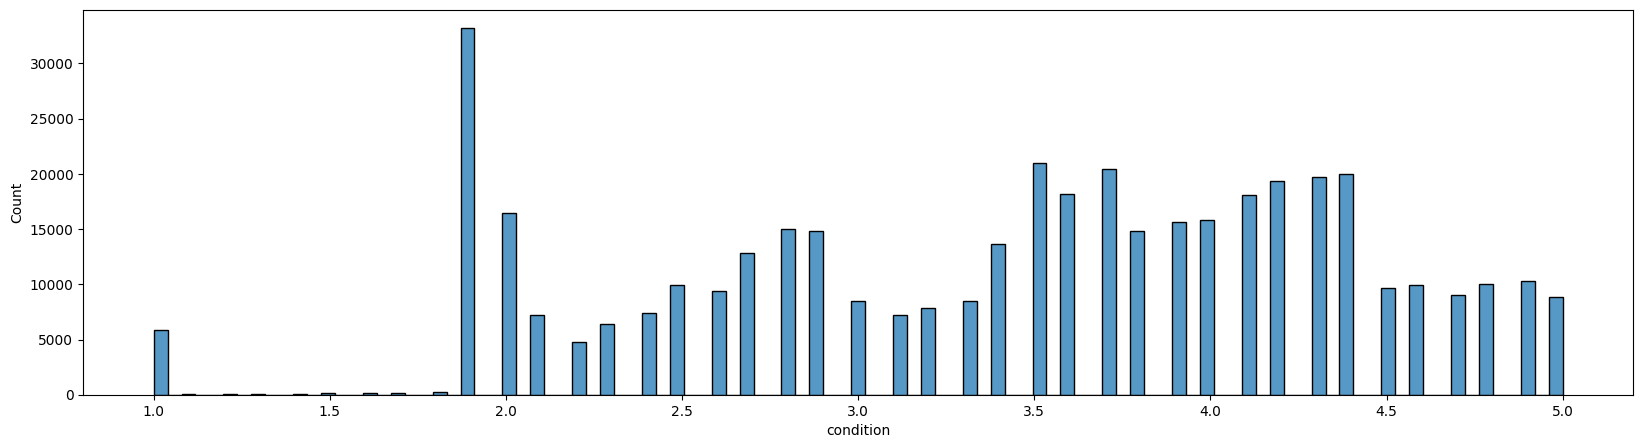

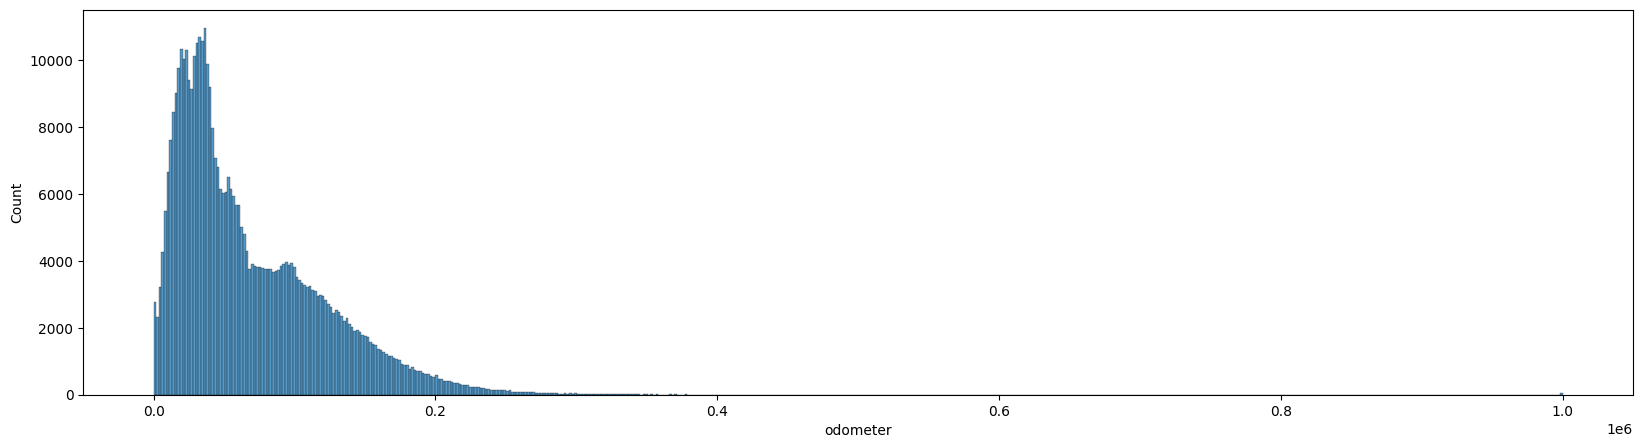

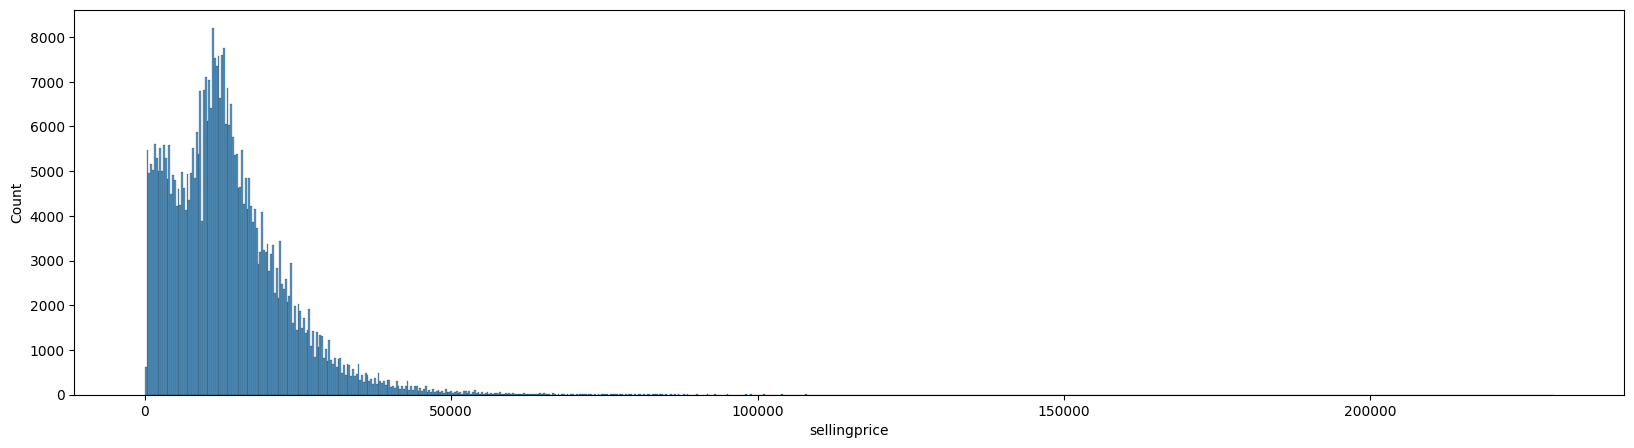

In [ ]:
hist_my_data(df_train)

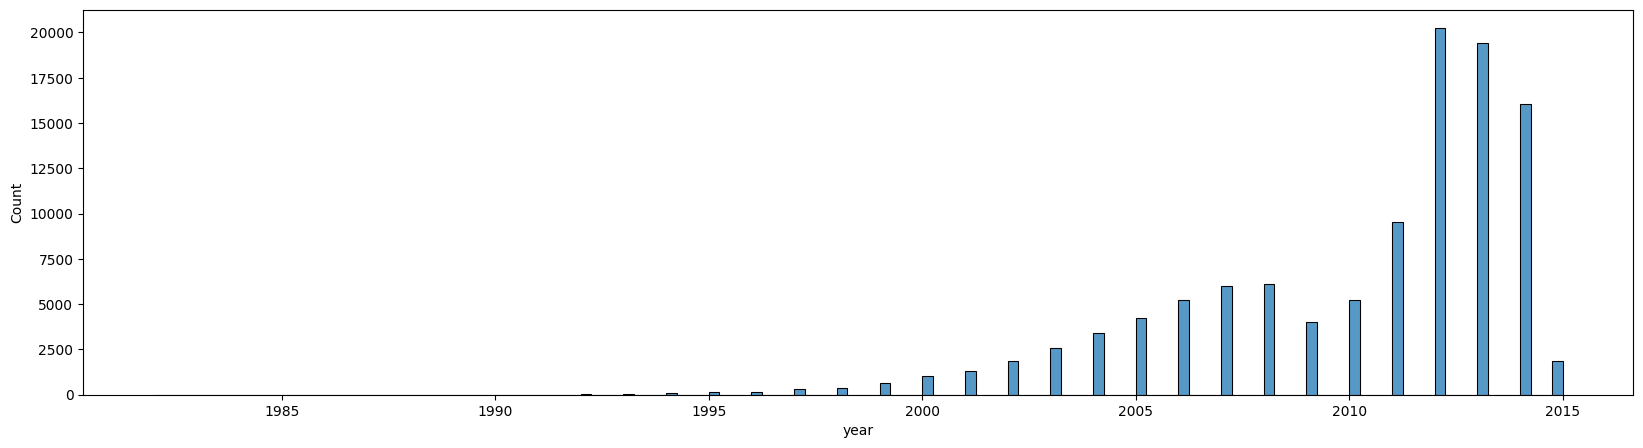

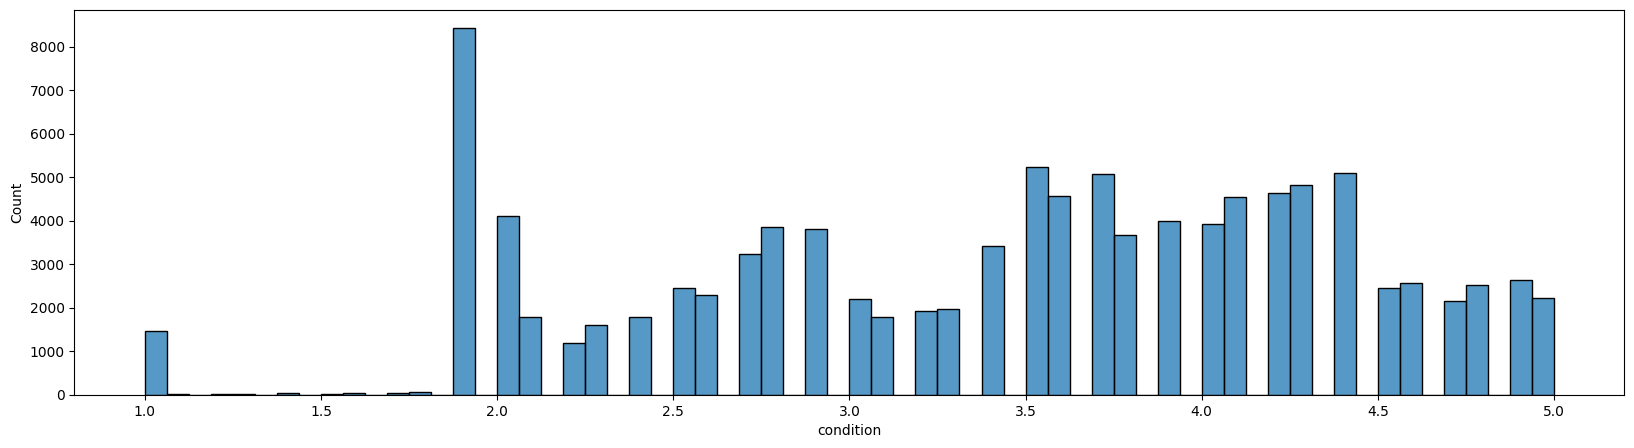

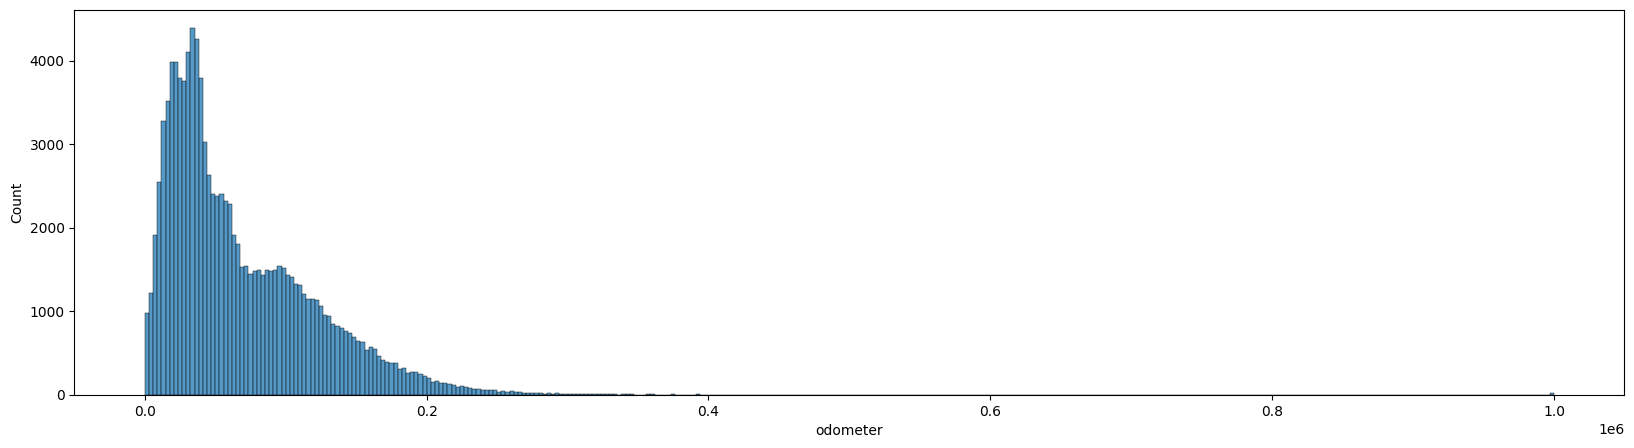

In [ ]:
hist_my_data(df_test)

### year

In [ ]:
def describe_year(df):
  print('Уникальные значения:', df.year.sort_values().unique())
  print('Пропусков:', df.year.isna().sum())

In [ ]:
describe_year(df_train)

Уникальные значения: [1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995
 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009
 2010 2011 2012 2013 2014 2015]
Пропусков: 0


In [ ]:
describe_year(df_test)

Уникальные значения: [1982 1984 1986 1987 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998
 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012
 2013 2014 2015]
Пропусков: 0


В столбце Year нет пропусков и выбросов. Оставляем как есть.

### saledate


Извлечем год и месяц из даты

In [ ]:
def extract_date(df):
  df['saledate'] = pd.to_datetime(df['saledate'], utc=True)
  df['sale_year'] = df['saledate'].dt.year
  df['sale_month'] = df['saledate'].dt.month
  df = df.drop(columns='saledate', inplace=True)

In [ ]:
extract_date(df_train)
extract_date(df_test)

Проверим наличие в данных записей, когда год продажи меньше года производства.

In [ ]:
len(df_train.query('sale_year < year'))

166

Удалим такие записи

In [ ]:
df_train = df_train[df_train.sale_year >= df_train.year]

In [ ]:
len(df_train.query('sale_year < year'))

0

### make

Переводим все в нижний регистр.

In [ ]:
def change_make(df):
  print('Уникальные значения до преобразования', df.make.unique())
  # переводим в нижний регистр
  df.loc[df.make.notna(),'make'] = df.loc[df.make.notna(),'make'].apply(lambda x: x.lower().strip())
  # правим дубликаты
  df.loc[df['make'].isin(['mercedes', 'mercedes-b']), 'make'] = 'mercedes-benz'
  df.loc[df['make'] == 'dodge tk', 'make'] = 'dodge'
  df.loc[df['make'] == 'mazda tk', 'make'] = 'mazda'
  df.loc[df['make'] == 'landrover', 'make'] = 'land rover'
  df.loc[df['make'] == 'vw', 'make'] = 'volkswagen'
  print('Уникальные значения после преобразования', df.make.unique())

In [ ]:
change_make(df_train)

Уникальные значения до преобразования ['Ford' 'Nissan' 'HUMMER' 'Lincoln' 'pontiac' 'Hyundai' nan 'Buick'
 'Chevrolet' 'Honda' 'Acura' 'Cadillac' 'GMC' 'Saab' 'Dodge'
 'Mercedes-Benz' 'Toyota' 'Volkswagen' 'BMW' 'Infiniti' 'Chrysler' 'Kia'
 'Jaguar' 'Subaru' 'Jeep' 'Lexus' 'mercedes' 'Scion' 'FIAT' 'Suzuki'
 'Mazda' 'Volvo' 'Audi' 'MINI' 'Isuzu' 'Mitsubishi' 'smart' 'Pontiac'
 'Porsche' 'subaru' 'ford' 'Land Rover' 'chrysler' 'Saturn' 'mazda'
 'dodge' 'Ram' 'Oldsmobile' 'hyundai' 'Mercury' 'Bentley' 'toyota'
 'lincoln' 'Fisker' 'nissan' 'chevrolet' 'honda' 'porsche' 'mitsubishi'
 'lexus' 'bmw' 'Maserati' 'acura' 'jeep' 'mercury' 'Tesla' 'landrover'
 'vw' 'cadillac' 'buick' 'gmc truck' 'land rover' 'volkswagen'
 'Rolls-Royce' 'audi' 'Ferrari' 'suzuki' 'Plymouth' 'oldsmobile'
 'Lamborghini' 'gmc' 'Geo' 'ford truck' 'Aston Martin' 'plymouth' 'Daewoo'
 'maserati' 'kia' 'mercedes-b' 'dodge tk' 'mazda tk' 'dot' 'airstream']
Уникальные значения после преобразования ['ford' 'nissan' 'hummer' '

In [ ]:
change_make(df_test)

Уникальные значения до преобразования ['Cadillac' 'GMC' 'Nissan' 'Chevrolet' 'Volkswagen' 'Hyundai' 'Ford'
 'Infiniti' 'Subaru' 'Kia' 'BMW' nan 'Mitsubishi' 'Dodge' 'Oldsmobile'
 'Volvo' 'Pontiac' 'Acura' 'Honda' 'Toyota' 'Audi' 'Jeep' 'Lincoln'
 'Chrysler' 'Mercedes-Benz' 'Ram' 'Scion' 'Mercury' 'Lexus' 'Saturn'
 'Mazda' 'Porsche' 'MINI' 'smart' 'Buick' 'HUMMER' 'ford' 'chrysler'
 'Jaguar' 'mitsubishi' 'FIAT' 'Saab' 'mazda' 'Suzuki' 'Land Rover' 'bmw'
 'cadillac' 'oldsmobile' 'honda' 'acura' 'buick' 'landrover' 'Geo' 'lexus'
 'dodge' 'chevrolet' 'chev truck' 'nissan' 'Bentley' 'jeep' 'mercury'
 'toyota' 'gmc' 'Isuzu' 'Aston Martin' 'Maserati' 'land rover' 'kia'
 'subaru' 'Daewoo' 'vw' 'volkswagen' 'Tesla' 'mercedes' 'Ferrari'
 'hyundai' 'pontiac' 'Fisker' 'porsche' 'Rolls-Royce' 'Lotus' 'Plymouth'
 'hyundai tk' 'lincoln' 'ford tk' 'audi']
Уникальные значения после преобразования ['cadillac' 'gmc' 'nissan' 'chevrolet' 'volkswagen' 'hyundai' 'ford'
 'infiniti' 'subaru' 'kia' 'bmw' nan '

В данных есть поля где make, model и trim не заполнены, можно было бы попробовать вытащить эти данные из VIN номера, но так как таких данных не очень много, можно удалить такие строки.

In [ ]:
df_train = df_train[~(df_train.make.isna() & df_train.model.isna() & df_train.trim.isna())]
len(df_train[df_train.make.isna()])

0

### model

In [ ]:
def change_to_lower(df, column):
  print('Уникальных значений до преобразования', len(df[column].unique()))
  df.loc[df[column].notna(), column] = df.loc[df[column].notna(), column].apply(lambda x: x.lower().strip())
  print('Уникальных значений после преобразования', len(df[column].unique()))

In [ ]:
df_train['model'].sort_values().unique()

array(['1 Series', '1500', '190-Class', '2 Series', '200', '200SX',
       '2500', '3', '3 Series', '3 Series Gran Turismo', '300',
       '300-Class', '3000GT', '300M', '300ZX', '300e', '320i', '323i',
       '328i', '3500', '350Z', '350z', '370Z', '4 Series',
       '4 Series Gran Coupe', '400-Class', '420-Class', '420sel', '42c',
       '458 Italia', '4Runner', '5 Series', '5 Series Gran Turismo',
       '500', '500-Class', '500L', '500e', '6', '6 Series',
       '6 Series Gran Coupe', '626', '7', '7 Series', '750i', '750li',
       '750lxi', '8 Series', '850', '9-2X', '9-3', '9-5', '9-7X', '911',
       '940', '960', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'ATS', 'Acadia',
       'Accent', 'Accord', 'Accord Crosstour', 'Accord Hybrid',
       'ActiveHybrid 5', 'ActiveHybrid 7', 'ActiveHybrid X6', 'Aerio',
       'Alero', 'Altima', 'Altima Hybrid', 'Amanti', 'Amigo', 'Armada',
       'Ascender', 'Aspen', 'Aspire', 'Astra', 'Astro', 'Astro Cargo',
       'Aura', 'Aura Hybrid', 'Aurora', 

In [ ]:
change_to_lower(df_train, 'model')

Уникальных значений до преобразования 960
Уникальных значений после преобразования 840


In [ ]:
change_to_lower(df_test, 'model')

Уникальных значений до преобразования 825
Уникальных значений после преобразования 747


Пропуски заполним следующим образом - зная значение в поле trim мы можем посмотреть какая модель чаще всего втречается с таким параметром и заполнить этим значением поле model.

In [ ]:
def fill_values(df, col1, col2):
  '''
  col1 - столбец, который заполняем
  col2 - столбец, по которому заполняем
  '''
  print(f'Пропусков до преобразования {len(df[df[col1].isna()])}')
  items = df[df[col1].isna()][col2].value_counts().index
  for item in items:
    try:
      df.loc[(df[col1].isna()) & (df[col2] == item), col1] = df.loc[(df[col1].isna()) & (df[col2] == item), col1].fillna(df[df[col2] == item][col1].value_counts().index[0])
    except:
      pass
  print(f'Пропусков после преобразования {len(df[df[col1].isna()])}')

In [ ]:
df_train.loc[(df_train.model.isna()) & (df_train.trim == '2.0 TFSI Premium quattro'), 'model'] = 'a4'
fill_values(df_train, 'model', 'trim')

Пропусков до преобразования 70
Пропусков после преобразования 0


In [ ]:
df_test.loc[(df_test.model.isna()) & (df_test.trim == '2.0 TFSI Premium quattro'), 'model'] = 'a4'
fill_values(df_test, 'model', 'trim')

Пропусков до преобразования 2077
Пропусков после преобразования 2061


### trim

In [ ]:
change_to_lower(df_train, 'trim')

Уникальных значений до преобразования 1923
Уникальных значений после преобразования 1841


In [ ]:
change_to_lower(df_test, 'trim')

Уникальных значений до преобразования 1497
Уникальных значений после преобразования 1449


Аналогично полю model поступим и с полем trim - зная значение в поле model мы можем посмотреть какая комплектация чаще всего втречается с таким параметром и заполнить этим значением поле trim.

In [ ]:
fill_values(df_train, 'trim', 'model')

Пропусков до преобразования 294
Пропусков после преобразования 92


In [ ]:
fill_values(df_test, 'trim', 'model')

Пропусков до преобразования 2114
Пропусков после преобразования 2082


### body

In [ ]:
change_to_lower(df_train, 'body')

Уникальных значений до преобразования 86
Уникальных значений после преобразования 46


In [ ]:
change_to_lower(df_test, 'body')

Уникальных значений до преобразования 78
Уникальных значений после преобразования 43


Заполняем по полям model, trim, make.

In [ ]:
fill_values(df_train, 'body', 'model')
fill_values(df_train, 'body', 'trim')
fill_values(df_train, 'body', 'make')

Пропусков до преобразования 2350
Пропусков после преобразования 785
Пропусков до преобразования 785
Пропусков после преобразования 695
Пропусков до преобразования 695
Пропусков после преобразования 1


In [ ]:
fill_values(df_test, 'body', 'model')
fill_values(df_test, 'body', 'trim')
fill_values(df_test, 'body', 'make')

Пропусков до преобразования 2594
Пропусков после преобразования 2240
Пропусков до преобразования 2240
Пропусков после преобразования 2213
Пропусков до преобразования 2213
Пропусков после преобразования 2062


### transmission

In [ ]:
df_train.transmission.sort_values().unique()

array(['automatic', 'manual', nan], dtype=object)

Заполним по полю model

In [ ]:
fill_values(df_train, 'transmission', 'model')

Пропусков до преобразования 50060
Пропусков после преобразования 19


In [ ]:
fill_values(df_test, 'transmission', 'model')

Пропусков до преобразования 13011
Пропусков после преобразования 370


Заменим этот признак на is_automatic, который будет индикактором автоматической коробки передач.

In [ ]:
def replace_is_automatic(df):
  df['is_automatic'] = df[['transmission']] == 'automatic'
  df['is_automatic'] = df['is_automatic'].astype('int')
  df.drop(columns=['transmission'], inplace=True)

In [ ]:
replace_is_automatic(df_train)

In [ ]:
replace_is_automatic(df_test)

### vin

In [ ]:
def describe_column(df, column='vin'):
  print('Количество пропусков', df[column].isna().sum())
  print('Количество дубликатов', df[column].duplicated().sum())

In [ ]:
describe_column(df_train)

Количество пропусков 0
Количество дубликатов 0


In [ ]:
describe_column(df_test)

Количество пропусков 0
Количество дубликатов 0


В поле vin нет пропусков и дубликатов

### state

In [ ]:
describe_column(df_train, 'state')

Количество пропусков 0
Количество дубликатов 431989


In [ ]:
describe_column(df_test, 'state')

Количество пропусков 0
Количество дубликатов 110020


In [ ]:
df_train.state.sort_values().unique()

array(['ab', 'al', 'az', 'ca', 'co', 'fl', 'ga', 'hi', 'il', 'in', 'la',
       'ma', 'md', 'mi', 'mn', 'mo', 'ms', 'nc', 'ne', 'nj', 'nm', 'ns',
       'nv', 'ny', 'oh', 'ok', 'on', 'or', 'pa', 'pr', 'qc', 'sc', 'tn',
       'tx', 'ut', 'va', 'wa', 'wi'], dtype=object)

In [ ]:
df_test.state.sort_values().unique()

array(['ab', 'al', 'az', 'ca', 'co', 'fl', 'ga', 'hi', 'il', 'in', 'la',
       'ma', 'md', 'mi', 'mn', 'mo', 'ms', 'nc', 'ne', 'nj', 'nm', 'ns',
       'nv', 'ny', 'oh', 'ok', 'on', 'or', 'pa', 'pr', 'qc', 'sc', 'tn',
       'tx', 'ut', 'va', 'wa', 'wi'], dtype=object)

С полем state все хорошо

### condition


In [ ]:
describe_column(df_train, 'condition')

Количество пропусков 9314
Количество дубликатов 431985


In [ ]:
describe_column(df_test, 'condition')

Количество пропусков 2379
Количество дубликатов 110016


В поле condition обнаружилось много пропусков. Можно проверить как зависит состояние автомобиля от года выпуска.

In [ ]:
df_train.condition.corr(df_train.year)

0.5508631425060206

Между годом выпуска и состоянием присутствует средняя корреляция, можно заменить это значение на медианное по каждому году.

In [ ]:
def fill_condition_with_median(df, col1='condition', col2='year'):
  '''
  col1 - столбец, который заполняем
  col2 - столбец, по которому заполняем
  '''
  print(f'Пропусков до преобразования {len(df[df[col1].isna()])}')
  years = df['year'].unique()
  for year in years:
    try:
      median = df[df['year'] == year]['condition'].median()
      df.loc[(df[col1].isna()) & (df[col2] == year), col1] = df.loc[(df[col1].isna()) & (df[col2] == year), col1].fillna(median)
    except:
      pass
  print(f'Пропусков после преобразования {len(df[df[col1].isna()])}')

In [ ]:
fill_condition_with_median(df_train)

Пропусков до преобразования 9314
Пропусков после преобразования 0


In [ ]:
fill_condition_with_median(df_test)

Пропусков до преобразования 2379
Пропусков после преобразования 0


### odometer

Посмотрим на описательную статистику и на боксплот распределения

In [ ]:
df_train['odometer'].describe()

count    431960.000000
mean      67582.718821
std       53070.296633
min           1.000000
25%       28035.000000
50%       51265.500000
75%       98096.000000
max      999999.000000
Name: odometer, dtype: float64

<Axes: >

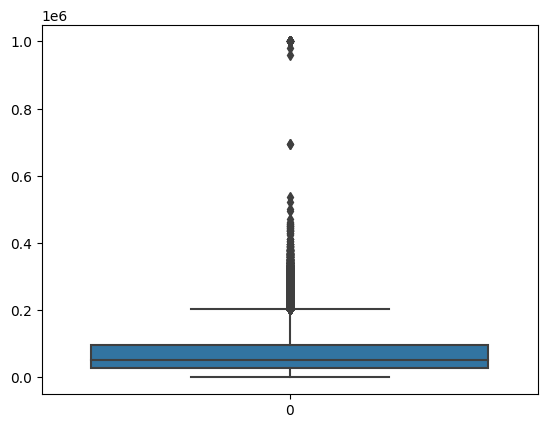

In [ ]:
sns.boxplot(df_train['odometer'])

Можно заметить, что в данных присутсвуют выбросы и очень маленькие значения. Выбросами будет считать значения за границей Q3+1.5*IQR.

Исправим выбросы следующим образом - заменим эти значение медианой пробега, которая считается за время от выпуска автомобиля, до его продажи. Для этого найдем медиану пробега за 1 год эксплуатации по всей выборке и домножим это значение на количество лет эксплуатации автомобиля.
Помимо этого также заменим значения пробега меньше 10.

In [ ]:
def replace_odometer(df):
  median = df['odometer'].median() / (df['sale_year'].median() - df['year'].median())
  IQR = df['odometer'].describe()['75%'] - df['odometer'].describe()['25%']
  out_IQR =  IQR * 1.5 + df['odometer'].describe()['75%']
  print('Выбросов до преобразования', len(df[(df['odometer'] > out_IQR) | (df['odometer'] < 10)]))
  df.loc[(df['odometer'] > out_IQR) | (df['odometer'] < 10), 'odometer'] = (df.loc[df['odometer'] > out_IQR, 'sale_year'] -
                                                                    df.loc[df['odometer'] > out_IQR, 'year']) * median
  print('Выбросов после преобразования', len(df[(df['odometer'] > out_IQR) | (df['odometer'] < 10)]))

In [ ]:
replace_odometer(df_train)

Выбросов до преобразования 9312
Выбросов после преобразования 4571


In [ ]:
replace_odometer(df_test)

Выбросов до преобразования 2303
Выбросов после преобразования 1090


Удаляем выбросы.

In [ ]:
df_train = df_train[df_train['odometer'] < 250000]

### color

In [ ]:
def replace_dash(df, column):
  '''
  column - столбец, где заменяем тире
  '''
  print('Уникальные значения до преобразования', df[column].sort_values().unique())
  df.loc[df[column] == '—', column] = np.nan
  print('Уникальные значения после преобразования', df[column].sort_values().unique())

In [ ]:
replace_dash(df_train, 'color')

Уникальные значения до преобразования ['beige' 'black' 'blue' 'brown' 'burgundy' 'charcoal' 'gold' 'gray'
 'green' 'lime' 'off-white' 'orange' 'pink' 'purple' 'red' 'silver'
 'turquoise' 'white' 'yellow' '—' nan]
Уникальные значения после преобразования ['beige' 'black' 'blue' 'brown' 'burgundy' 'charcoal' 'gold' 'gray'
 'green' 'lime' 'off-white' 'orange' 'pink' 'purple' 'red' 'silver'
 'turquoise' 'white' 'yellow' nan]


In [ ]:
replace_dash(df_test, 'color')

Уникальные значения до преобразования ['beige' 'black' 'blue' 'brown' 'burgundy' 'charcoal' 'gold' 'gray'
 'green' 'lime' 'off-white' 'orange' 'pink' 'purple' 'red' 'silver'
 'turquoise' 'white' 'yellow' '—' nan]
Уникальные значения после преобразования ['beige' 'black' 'blue' 'brown' 'burgundy' 'charcoal' 'gold' 'gray'
 'green' 'lime' 'off-white' 'orange' 'pink' 'purple' 'red' 'silver'
 'turquoise' 'white' 'yellow' nan]


### interior


In [ ]:
replace_dash(df_train, 'interior')

Уникальные значения до преобразования ['beige' 'black' 'blue' 'brown' 'burgundy' 'gold' 'gray' 'green'
 'off-white' 'orange' 'purple' 'red' 'silver' 'tan' 'white' 'yellow' '—'
 nan]
Уникальные значения после преобразования ['beige' 'black' 'blue' 'brown' 'burgundy' 'gold' 'gray' 'green'
 'off-white' 'orange' 'purple' 'red' 'silver' 'tan' 'white' 'yellow' nan]


In [ ]:
replace_dash(df_test, 'interior')

Уникальные значения до преобразования ['beige' 'black' 'blue' 'brown' 'burgundy' 'gold' 'gray' 'green'
 'off-white' 'orange' 'purple' 'red' 'silver' 'tan' 'white' 'yellow' '—'
 nan]
Уникальные значения после преобразования ['beige' 'black' 'blue' 'brown' 'burgundy' 'gold' 'gray' 'green'
 'off-white' 'orange' 'purple' 'red' 'silver' 'tan' 'white' 'yellow' nan]


### seller

Столбец seller можно удалить, так как эти данные не относятся к параметрам автомобиля.

In [ ]:
df_train.drop(columns='seller', inplace=True)
df_test.drop(columns='seller', inplace=True)

### sellingprice

In [ ]:
df_train.sellingprice.describe()

count    428782.000000
mean      13761.826058
std        9700.571440
min         100.000000
25%        7100.000000
50%       12300.000000
75%       18300.000000
max      230000.000000
Name: sellingprice, dtype: float64

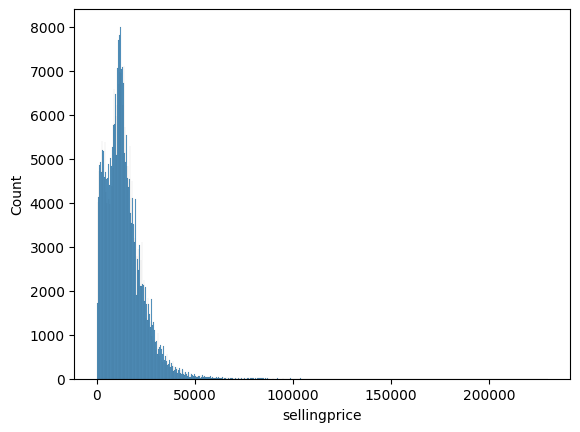

In [ ]:
sns.histplot(df_train.sellingprice);

Удаляем выбросы.

In [ ]:
df_train = df_train[df_train.sellingprice > 10]
df_train = df_train[df_train.sellingprice < (df_train.sellingprice.describe()['75%'] + (df_train.sellingprice.describe()['75%'] - df_train.sellingprice.describe()['25%']) * 1.5)]

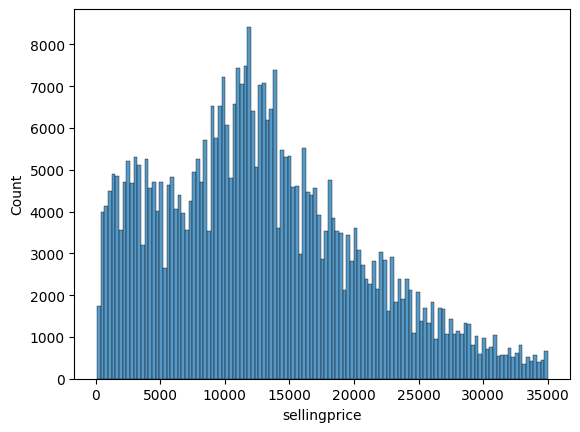

In [ ]:
sns.histplot(df_train.sellingprice);

# ML



## Подготовка признаков

In [ ]:
columns_to_drop = ['vin']
df_for_train = df_train.drop(columns=columns_to_drop)
df_test_pr = df_test.drop(columns=columns_to_drop)

df_for_train.drop_duplicates(inplace=True)

features = df_for_train.drop(columns=['sellingprice'])
target = df_for_train.sellingprice

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.3, random_state=0)

num_features = features.select_dtypes(include=('number')).columns.tolist()
cat_features = features.select_dtypes('object').columns.tolist()
num_features, cat_features

(['year', 'condition', 'odometer', 'sale_year', 'sale_month', 'is_automatic'],
 ['make', 'model', 'trim', 'body', 'state', 'color', 'interior'])

## Pipeline

In [ ]:
def make_ct():

  num_pipeline = Pipeline(steps=[
      ('imputer', KNNImputer()),
      ('scaler', MinMaxScaler(feature_range=(0, 1)))
      ])

  cat_pipeline = Pipeline(steps=[
      ('imputer', SimpleImputer(strategy='constant', fill_value='nan')),
      # ('one-hot', OneHotEncoder(handle_unknown='ignore', drop='first'))
      ])

  column_transformer = ColumnTransformer(transformers=[('num', num_pipeline, num_features),
                                                     ('cat', cat_pipeline, cat_features)],
                                         remainder='passthrough'
                                        )

  return column_transformer
column_transformer = make_ct()

In [ ]:
class Preparer(BaseEstimator, TransformerMixin):

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    X = pd.DataFrame(data=X, columns=num_features+cat_features)
    return X

In [ ]:
def make_pipeline(model):
  pipeline = Pipeline(steps=[('transoformer', make_ct()),
                           ('preparer', Preparer()),
                           ('model', model)
                            ])
  return pipeline
pipeline = make_pipeline(CatBoostRegressor(cat_features=cat_features, verbose=100))
pipeline

Pipeline(steps=[('transoformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['year', 'condition',
                                                   'odometer', 'sale_year',
                                                   'sale_month',
                                                   'is_automatic']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='nan',
                                                                                 strategy='constant'))]),
                                                  ['make', 'model', 'trim',
                                                   'body', 'state', 'color',
                                                   'interior'])])),
                ('preparer', Preparer()),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x7c9389657c10>)])

## Важность признаков

In [ ]:
pipeline.fit(features_train, target_train)

Learning rate set to 0.10036
0:	learn: 7187.0670749	total: 540ms	remaining: 8m 59s
100:	learn: 2370.0406879	total: 40.1s	remaining: 5m 57s
200:	learn: 2108.0083941	total: 1m 20s	remaining: 5m 19s
300:	learn: 1993.0105659	total: 2m	remaining: 4m 40s
400:	learn: 1917.7720661	total: 2m 42s	remaining: 4m 2s
500:	learn: 1863.8810571	total: 3m 24s	remaining: 3m 23s
600:	learn: 1815.2692379	total: 4m 22s	remaining: 2m 53s
700:	learn: 1780.2290285	total: 5m 3s	remaining: 2m 9s
800:	learn: 1751.9948242	total: 5m 47s	remaining: 1m 26s
900:	learn: 1728.5948310	total: 6m 30s	remaining: 42.9s
999:	learn: 1708.9370958	total: 7m 12s	remaining: 0us


Pipeline(steps=[('transoformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['year', 'condition',
                                                   'odometer', 'sale_year',
                                                   'sale_month',
                                                   'is_automatic']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='nan',
                                                                                 strategy='constant'))]),
                                                  ['make', 'model', 'trim',
                                                   'body', 'state', 'color',
                                                   'interior'])])),
                ('preparer', Preparer()),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x7c9389657c10>)])

In [ ]:
importances = pd.DataFrame({"features": pipeline[-1].feature_names_, "scores": pipeline[-1].feature_importances_}).sort_values(by='scores', ascending=False)
importances

,features,scores
0,year,18.796935
6,make,18.242721
2,odometer,16.523062
9,body,16.428683
7,model,15.727709
8,trim,7.145376
1,condition,5.320104
12,interior,0.737364
10,state,0.509582
4,sale_month,0.319811


Формируем итоговый список признаков

In [ ]:
columns_to_drop = importances.loc[importances['scores'] < 10, 'features'].tolist()
columns_to_drop.append('vin')
columns_to_drop

['trim',
 'condition',
 'interior',
 'state',
 'sale_month',
 'is_automatic',
 'color',
 'sale_year',
 'vin']

In [ ]:
df_for_train = df_train.drop(columns=columns_to_drop)
df_test_pr = df_test.drop(columns=columns_to_drop)

df_for_train.drop_duplicates(inplace=True)

features = df_for_train.drop(columns=['sellingprice'])
target = df_for_train.sellingprice

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.3, random_state=0)

num_features = features.select_dtypes(include=('number')).columns.tolist()
cat_features = features.select_dtypes('object').columns.tolist()
num_features, cat_features

(['year', 'odometer'], ['make', 'model', 'body'])

In [ ]:
column_transformer = make_ct()

## Optuna

Качество модели будет оцениваться по метрике MAPE

In [ ]:
def objective(trial):

  params = {
    "iterations": trial.suggest_int("iterations", 1, 1000),
    "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
    "depth": trial.suggest_int("depth", 5, 15)
    # "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
    # "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
  }

  model = CatBoostRegressor(**params, cat_features=cat_features, verbose=100)

  pipeline = Pipeline(steps=[('transoformer', column_transformer),
                           ('preparer', Preparer()),
                           ('model', model)
                    ])

  pipeline.fit(features_train, target_train)

  mape = mean_absolute_percentage_error(pipeline.predict(features_valid), target_valid)

  return mape

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5)
study.best_value, study.best_params

[I 2023-08-23 07:42:38,368] A new study created in memory with name: no-name-5103e92f-5abc-42f8-9a2f-18575f8faf4f


0:	learn: 6728.2497796	total: 788ms	remaining: 3m 17s
100:	learn: 2125.4035614	total: 1m 20s	remaining: 1m 59s
200:	learn: 2028.7589682	total: 2m 41s	remaining: 40.2s
250:	learn: 1997.9125371	total: 3m 23s	remaining: 0us


[I 2023-08-23 07:46:05,641] Trial 0 finished with value: 0.1583145362878909 and parameters: {'iterations': 251, 'learning_rate': 0.17990491192796293, 'depth': 14}. Best is trial 0 with value: 0.1583145362878909.


0:	learn: 7495.7655061	total: 207ms	remaining: 30.8s
100:	learn: 3340.1233805	total: 9.48s	remaining: 4.6s
149:	learn: 3104.1064811	total: 15.2s	remaining: 0us


[I 2023-08-23 07:46:22,361] Trial 1 finished with value: 0.20164768838451064 and parameters: {'iterations': 150, 'learning_rate': 0.03894849335797291, 'depth': 7}. Best is trial 0 with value: 0.1583145362878909.


0:	learn: 7164.8449030	total: 515ms	remaining: 6m 18s
100:	learn: 2247.2242318	total: 58.6s	remaining: 6m 8s
200:	learn: 2128.0732239	total: 1m 57s	remaining: 5m 12s
300:	learn: 2075.3877225	total: 2m 58s	remaining: 4m 18s
400:	learn: 2042.0958445	total: 4m 1s	remaining: 3m 21s
500:	learn: 2014.8522936	total: 5m 5s	remaining: 2m 23s
600:	learn: 1993.4051070	total: 6m 9s	remaining: 1m 23s
700:	learn: 1975.1149207	total: 7m 16s	remaining: 21.8s
735:	learn: 1968.6098315	total: 7m 40s	remaining: 0us


[I 2023-08-23 07:54:10,778] Trial 2 finished with value: 0.15439459386110177 and parameters: {'iterations': 736, 'learning_rate': 0.09823343088129383, 'depth': 13}. Best is trial 2 with value: 0.15439459386110177.


0:	learn: 6901.6624104	total: 225ms	remaining: 2m 14s
100:	learn: 2469.0522548	total: 18.1s	remaining: 1m 29s
200:	learn: 2331.0735321	total: 37.2s	remaining: 1m 13s
300:	learn: 2276.2784972	total: 56.6s	remaining: 55.6s
400:	learn: 2243.4182605	total: 1m 20s	remaining: 39.4s
500:	learn: 2219.1219015	total: 1m 39s	remaining: 19s
596:	learn: 2199.3605759	total: 1m 58s	remaining: 0us


[I 2023-08-23 07:56:12,409] Trial 3 finished with value: 0.18797729130618412 and parameters: {'iterations': 597, 'learning_rate': 0.15551710230976726, 'depth': 7}. Best is trial 2 with value: 0.15439459386110177.


0:	learn: 7322.7216078	total: 515ms	remaining: 3m 28s
100:	learn: 2312.4060684	total: 55.1s	remaining: 2m 46s
200:	learn: 2183.9420442	total: 1m 52s	remaining: 1m 54s
300:	learn: 2125.2800673	total: 2m 51s	remaining: 59.7s
400:	learn: 2086.8424076	total: 3m 51s	remaining: 2.89s
405:	learn: 2085.5266131	total: 3m 54s	remaining: 0us


[I 2023-08-23 08:00:10,477] Trial 4 finished with value: 0.16486590358213116 and parameters: {'iterations': 406, 'learning_rate': 0.06899324129145172, 'depth': 13}. Best is trial 2 with value: 0.15439459386110177.


(0.15439459386110177,
 {'iterations': 736, 'learning_rate': 0.09823343088129383, 'depth': 13})

Итоговый пайплайн

In [ ]:
pipeline = make_pipeline(CatBoostRegressor(**study.best_params, cat_features=cat_features, verbose=100))
pipeline

Pipeline(steps=[('transoformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['year', 'odometer']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='nan',
                                                                                 strategy='constant'))]),
                                                  ['make', 'model', 'body'])])),
                ('preparer', Preparer()),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x7c938a77a440>)])

## Submission

In [ ]:
pipeline.fit(pd.concat([features_train, features_valid], axis=0), pd.concat([target_train, target_valid], axis=0))

0:	learn: 7140.9312666	total: 1.2s	remaining: 14m 43s
100:	learn: 2227.1347858	total: 1m 13s	remaining: 7m 41s
200:	learn: 2128.4321415	total: 2m 30s	remaining: 6m 41s
300:	learn: 2084.9095108	total: 3m 50s	remaining: 5m 33s
400:	learn: 2054.9949989	total: 5m 11s	remaining: 4m 20s
500:	learn: 2030.9996106	total: 6m 35s	remaining: 3m 5s
600:	learn: 2012.6193935	total: 7m 58s	remaining: 1m 47s
700:	learn: 1997.0220509	total: 9m 25s	remaining: 28.2s
735:	learn: 1992.1096179	total: 9m 54s	remaining: 0us


Pipeline(steps=[('transoformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['year', 'odometer']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='nan',
                                                                                 strategy='constant'))]),
                                                  ['make', 'model', 'body'])])),
                ('preparer', Preparer()),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x7c938a77a440>)])

In [ ]:
sub = pd.DataFrame({"vin": df_test.vin, "sellingprice": pipeline.predict(df_test)})

In [ ]:
sub.to_csv('sub.csv', index=False)

# Выводы

В результате проделанной работы была разработана модель предсказания стоимости автомобиля на вторичном рынке. Финальная метрика MAPE  на валидационной выборке составила 15.4%, на тестовой 18,25%. Была изучена важность признаков, выявлено, что наиболее важными признаками являются - год, пробег, марка, модель и тип кузова автомобиля.